In [1]:

packages <- c(
    "ggplot2", 
    "dplyr", 
    "patchwork",
    "ggExtra"
)
for (pkg in packages) {
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                pkg,
                character.only = TRUE,
                quietly = TRUE,
                warn.conflicts = FALSE
            )
        )
    )
}

In [2]:
lm_results_file_path <- file.path(
    "../results/all_features_beta_df.parquet"
)
plot_save_dir <- file.path(
    "../figures"
)
if (!dir.exists(plot_save_dir)) {
    dir.create(plot_save_dir, recursive = TRUE)
}
plot_file_path <- file.path(
    plot_save_dir,
    "lm_coefficients.png"
)
lm_coeff_df <- arrow::read_parquet(lm_results_file_path)
# shuffle the row order for plotting purposes
lm_coeff_df <- lm_coeff_df %>%
    dplyr::mutate(
        row_id = 1:nrow(lm_coeff_df)
    ) %>%
    dplyr::arrange(dplyr::desc(row_id)) %>%
    dplyr::select(-row_id)
head(lm_coeff_df)

beta,p_value,variate,r2,feature,Compartment,Feature_type,Channel,Channel2,featurizer,feature_number,Measurement
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1.494347e-03,0.000000e+00,dose,0.5389225,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO
2.653720e-04,1.045346e-218,Cell count,0.5389225,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO
1.838784e-02,0.000000e+00,Time,0.5389225,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO
-2.185318e-01,0.000000e+00,const,0.5389225,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO
-2.266483e-04,0.000000e+00,dose,0.4133827,feature,scDINO,scDINO,DNA,NA,scDINO,99,scDINO
-9.564899e-05,4.276600e-37,Cell count,0.4133827,feature,scDINO,scDINO,DNA,NA,scDINO,99,scDINO


In [3]:
font_size <- 24
plot_themes <- (
    theme_bw()
    + theme(
        # legend.position = "bottom",
        legend.text = element_text(size = font_size),
        legend.title = element_text(size = font_size),
        axis.title.x = element_text(size = font_size),
        axis.text.x = element_text(size = font_size),
        axis.title.y = element_text(size = font_size),
        axis.text.y = element_text(size = font_size),
        strip.text = element_text(size = font_size),
    )
)

In [4]:
lm_coeff_df$log10p_value <- -log10(lm_coeff_df$p_value)
# remove the const from the variate column
lm_coeff_df <- lm_coeff_df %>%
    filter(
        !grepl("const", variate)
    )
# if the log10p is inf then set to the max value
lm_coeff_df$log10p_value[is.infinite(lm_coeff_df$log10p_value)] <- max(
    lm_coeff_df$log10p_value[!is.infinite(lm_coeff_df$log10p_value)]
)
head(lm_coeff_df)

beta,p_value,variate,r2,feature,Compartment,Feature_type,Channel,Channel2,featurizer,feature_number,Measurement,log10p_value
<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1.494347e-03,0.000000e+00,dose,0.5389225,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,309.3914
2.653720e-04,1.045346e-218,Cell count,0.5389225,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,217.9807
1.838784e-02,0.000000e+00,Time,0.5389225,feature,scDINO,scDINO,DNA,NA,scDINO,9,scDINO,309.3914
-2.266483e-04,0.000000e+00,dose,0.4133827,feature,scDINO,scDINO,DNA,NA,scDINO,99,scDINO,309.3914
-9.564899e-05,4.276600e-37,Cell count,0.4133827,feature,scDINO,scDINO,DNA,NA,scDINO,99,scDINO,36.3689
1.757088e-02,0.000000e+00,Time,0.4133827,feature,scDINO,scDINO,DNA,NA,scDINO,99,scDINO,309.3914


Warning message:
“Duplicated `override.aes` is ignored.”
Warning message:
“Duplicated `override.aes` is ignored.”


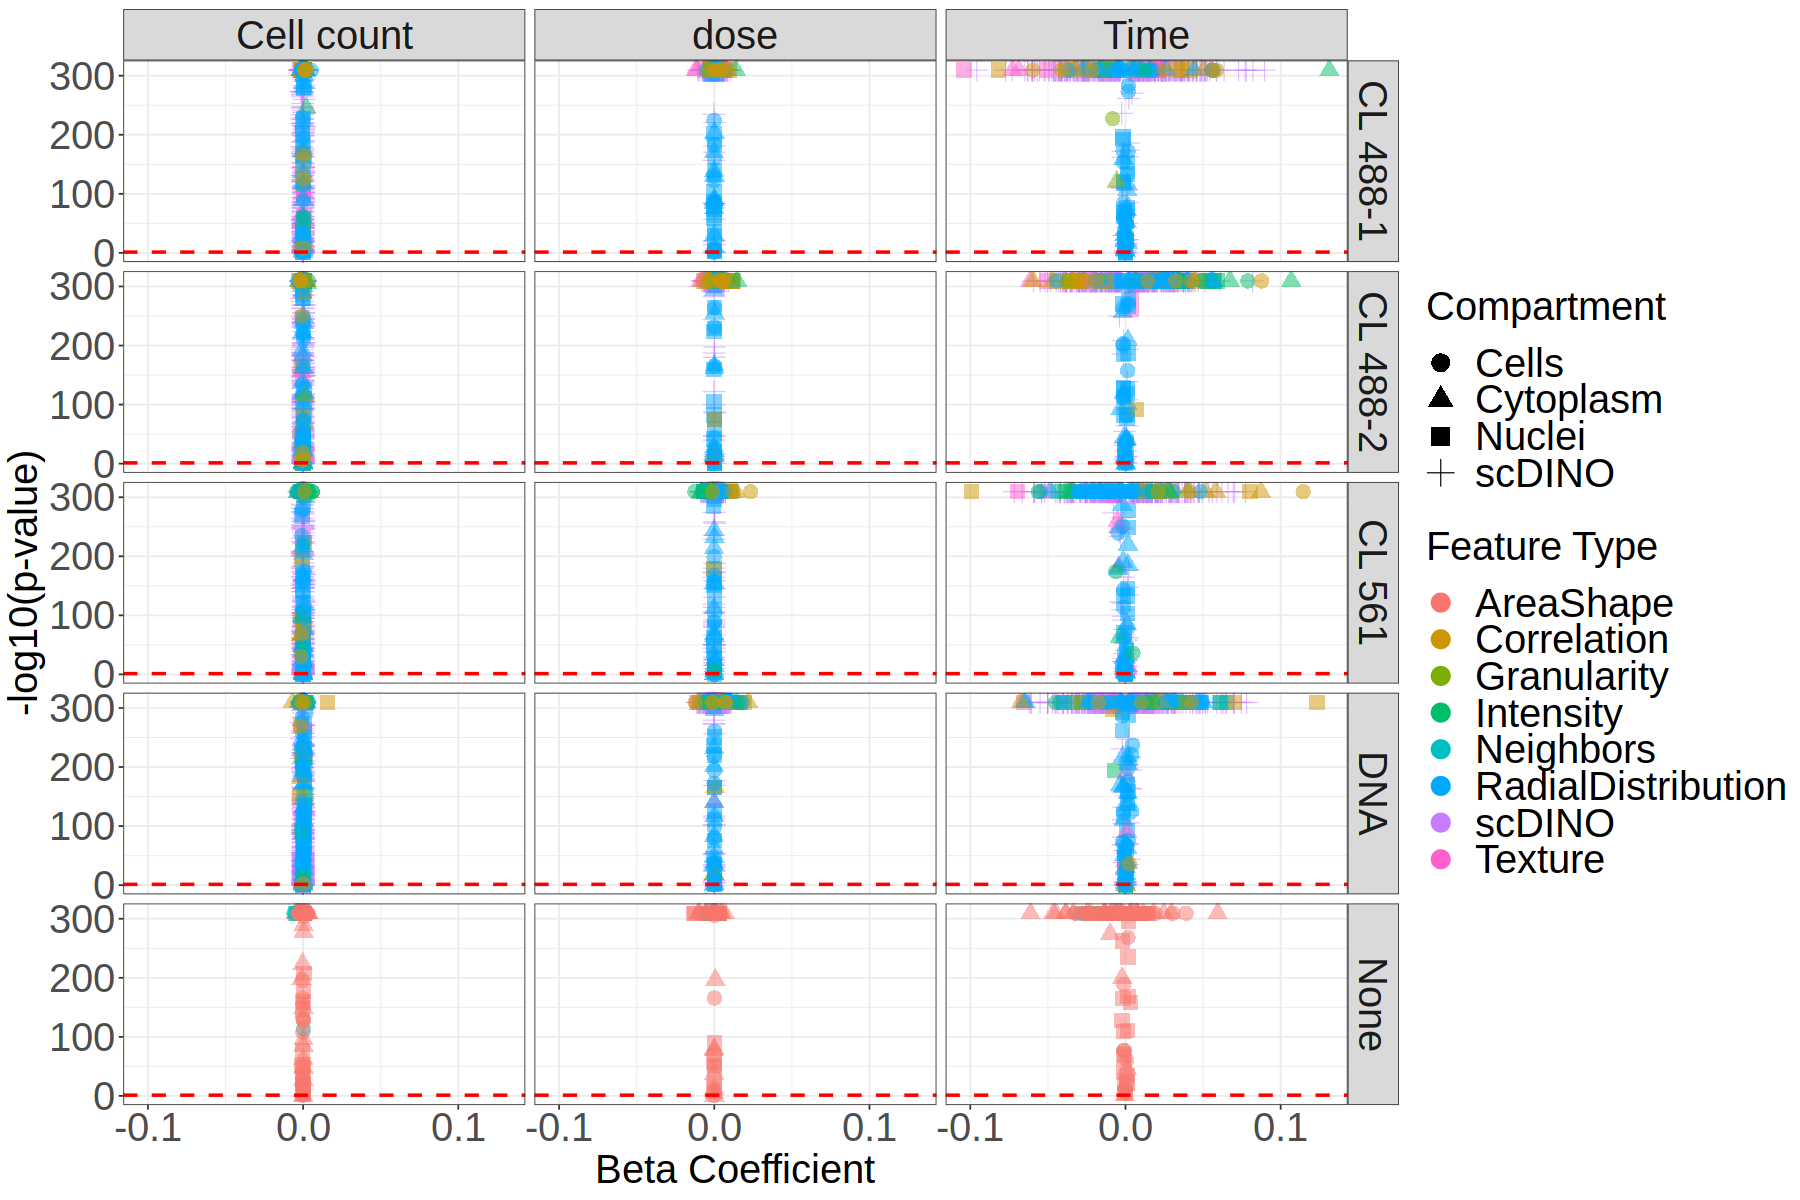

In [5]:
width <- 15
height <- 10
options(repr.plot.width = width, repr.plot.height = height)
lm_coeff_plot <- (
    ggplot(lm_coeff_df, aes(
        x = beta, 
        y = log10p_value, 
        fill = Feature_type, 
        # shape = Compartment
        )
    )
    + geom_point(
        aes(
            color = Feature_type,
            shape = Compartment
        ),
        alpha = 0.5,
        stroke = 0.5,
        size = 4
    )
    + labs(
        x = "Beta Coefficient",
        y = "-log10(p-value)"
    )
    + ylim(0, max(lm_coeff_df$log10p_value)+1)
    # horizontal line at y = -log10(0.05)
    + geom_hline(
        yintercept = -log10(0.05),
        linetype = "dashed",
        color = "red",
        linewidth = 1
    )
    # change the the x increments 
    + scale_x_continuous(
        breaks = seq(
            from = round(min(lm_coeff_df$beta),2),
            to = round(max(lm_coeff_df$beta),2),
            by = 0.1,
        )
    )
    + plot_themes
    + guides(
        fill = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Feature Type"
        ),
        color = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Feature Type"
        ),
    
        shape = guide_legend(
            override.aes = list(size = 5, alpha = 1),
            title = "Compartment"
        )
    )
    + facet_grid(
        Channel ~ variate,
    )
)
ggsave(
    filename = plot_file_path,
    plot = lm_coeff_plot,
    device = "png",
    width = width,
    height = height,
    dpi = 600,
    units = "in",
)
lm_coeff_plot     
